# Surveying dust structure via GALEX MIS

## Learning goals

By the end of this tutorial you will be able to:

- Understand NUV and FUV images and how they are useful to study dust
- Navigate the GALEX MIS catalog
- Create a mosaic from several images

## Introduction

**GALEX background**: The Galaxy Evolution Explorer (GALEX) was a satellite which mission was to produce an All-sky Imaiging Survey (AIS). It observed the sky in two different bands: in the Near UV (NUV) ($1750-27504$ Å) and in the Far UV (FUV) ($1350-1750$ Å). The GALEX database contains over 600 million source measurements in the ultraviolet domain, with some sources having more than one measurement, which could be useful to look for variability. 

## Imports

- _Observations_ from _astroquery.mast_ to query the Barbara A. Mikulski Archive for Space Telescopes (MAST).

In [47]:
from astroquery.mast import Observations
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from astropy.io import fits
from astropy.coordinates import SkyCoord
import os

## GALEX MIS

The objective of this tutorial is to create a mosaic of a high-latitude cloud using different images retrieved from GALEX MIS. The GALEX MIS products can be accesed through _astroquery.mast_, and we will perform a search using the galactic coordinates of some objects belonging to the Draco cloud ($l [deg], b [deg]$):

- 89.8 38.7
- 91.4 37.8
- 92.2 36.3
- 92.3 40.0
- 92.7 39.0
- 92.8 36.5
- 93.3 38.1 
- 95.5 38.1

In [3]:
l = np.array([89.8, 91.4, 92.2, 92.3, 92.7, 92.8, 93.3, 95.5]) # deg
b = np.array([38.7, 37.8, 36.3, 40.0, 39.0, 36.5, 38.1, 38.1]) # deg

### Unique source query

Let's start with only one source, and see step by step how to retrieve the image from the database, first let's use the coordinates of the source to find it in the database. We will use <a href="https://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html">_SkyCoord_</a> to correctly characterize the units and reference frame of our source. The coordinates displayed above are expressed in degrees and are in the galactic reference frame, we can specify this by using the arguments _unit_ and _frame_ as shown below:

In [41]:
coord = SkyCoord(l[0], b[0], unit='deg', frame='galactic')
obs = Observations.query_criteria(obs_collection="GALEX",coordinates=coord.icrs,radius="0.5 deg")
data_products = Observations.get_product_list(obs)
data_products

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str5,str5,str5,str19,str139,str1,str133,str9,str28,str12,str1,str3,str1,str1,str54,int64,str4,str6,int64
71914,GALEX,image,6371021184082903040,Catalog of matches between -flagstar and -[n/f]-cat files,S,mast:GALEX/url/data/GR6/pipe/02-vsn/50003-AIS_3/d/00-visits/0002-img/07-try/AIS_3_0002_sg12-fd-cat_mch_flagstar.fits.gz,AUXILIARY,--,--,--,AIS,--,--,AIS_3_0002_sg12-fd-cat_mch_flagstar.fits.gz,3933,9288,PUBLIC,2
71914,GALEX,image,6371021184082903040,Count map (J2000),S,mast:GALEX/url/data/GR6/pipe/02-vsn/50003-AIS_3/d/00-visits/0002-img/07-try/AIS_3_0002_sg12-fd-cnt.fits.gz,AUXILIARY,--,--,--,AIS,--,--,AIS_3_0002_sg12-fd-cnt.fits.gz,419852,9288,PUBLIC,2
71914,GALEX,image,6371021184082903040,Exposure map (J2000),S,mast:GALEX/url/data/GR6/pipe/02-vsn/50003-AIS_3/d/00-visits/0002-img/07-try/AIS_3_0002_sg12-fd-exp.fits.gz,AUXILIARY,--,--,--,AIS,--,--,AIS_3_0002_sg12-fd-exp.fits.gz,56619,9288,PUBLIC,2
71914,GALEX,image,6371021184082903040,Artifact and source star detailed info.,S,mast:GALEX/url/data/GR6/pipe/02-vsn/50003-AIS_3/d/00-visits/0002-img/07-try/AIS_3_0002_sg12-fd-flag_tbl.fits.gz,AUXILIARY,--,--,--,AIS,--,--,AIS_3_0002_sg12-fd-flag_tbl.fits.gz,2032,9288,PUBLIC,2
71914,GALEX,image,6371021184082903040,Artifact Flag image (J2000),S,mast:GALEX/url/data/GR6/pipe/02-vsn/50003-AIS_3/d/00-visits/0002-img/07-try/AIS_3_0002_sg12-fd-flags.fits.gz,AUXILIARY,--,--,--,AIS,--,--,AIS_3_0002_sg12-fd-flags.fits.gz,12234,9288,PUBLIC,2
71914,GALEX,image,6371021184082903040,Star catalog for flagging,S,mast:GALEX/url/data/GR6/pipe/02-vsn/50003-AIS_3/d/00-visits/0002-img/07-try/AIS_3_0002_sg12-fd-flagstar.fits.gz,AUXILIARY,--,--,--,AIS,--,--,AIS_3_0002_sg12-fd-flagstar.fits.gz,3651,9288,PUBLIC,2
71914,GALEX,image,6371021184082903040,Background subtracted intensity map (J2000),S,mast:GALEX/url/data/GR6/pipe/02-vsn/50003-AIS_3/d/00-visits/0002-img/07-try/AIS_3_0002_sg12-fd-intbgsub.fits.gz,AUXILIARY,--,--,--,AIS,--,--,AIS_3_0002_sg12-fd-intbgsub.fits.gz,4458358,9288,PUBLIC,2
71914,GALEX,image,6371021184082903040,Time-slice count maps (J2000),S,mast:GALEX/url/data/GR6/pipe/02-vsn/50003-AIS_3/d/00-visits/0002-img/07-try/AIS_3_0002_sg12-fd-movie.fits.gz,AUXILIARY,--,--,--,AIS,--,--,AIS_3_0002_sg12-fd-movie.fits.gz,173044,9288,PUBLIC,2
71914,GALEX,image,6371021184082903040,FUV extractions using NUV positions,S,mast:GALEX/url/data/GR6/pipe/02-vsn/50003-AIS_3/d/00-visits/0002-img/07-try/AIS_3_0002_sg12-fd-ncat.fits.gz,AUXILIARY,--,--,--,AIS,--,--,AIS_3_0002_sg12-fd-ncat.fits.gz,1721329,9288,PUBLIC,2


In [44]:
data_products_mrp = Observations.filter_products(data_products, productType='SCIENCE',productGroupDescription='Minimum Recommended Products')
yourProd = data_products_mrp[0]
yourProd

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str5,str5,str5,str19,str139,str1,str133,str9,str28,str12,str1,str3,str1,str1,str54,int64,str4,str6,int64
9288,GALEX,image,6371021321488302080,Intensity map (J2000),C,mast:GALEX/url/data/GR6/pipe/02-vsn/50003-AIS_3/d/01-main/0001-img/07-try/AIS_3_sg12-fd-int.fits.gz,SCIENCE,Minimum Recommended Products,Imaging Only,--,AIS,--,--,AIS_3_sg12-fd-int.fits.gz,2678412,9288,PUBLIC,2


In [46]:
table = Observations.download_products(yourProd, mrp_only = False, cache = False) 
table

Local Path,Status,Message,URL
str66,str8,object,object
./mastDownload/GALEX/6371021321488302080/AIS_3_sg12-fd-int.fits.gz,COMPLETE,None,None


In [54]:
filename = table['Local Path'][0]
os.system("gunzip " + filename)

0

In [57]:
fits.info(filename[:-3])

Filename: ./mastDownload/GALEX/6371021321488302080/AIS_3_sg12-fd-int.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     145   (3840, 3840)   float32   


In [58]:
with fits.open(filename[:-3]) as hdulist: 
    header1 = hdulist[0].header
    data1 = hdulist[0].data

print(repr(header1))

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 3840 / length of data axis 1                          
NAXIS2  =                 3840 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
LONGSTRN= 'OGIP 1.0'           / The HEASARC Long String Convention may be used.
COMMENT   This FITS file may contain long string keyword values that are        
COMMENT   continued over multiple keywords.  The HEASARC convention uses the &  
COMMENT   character at the end of each substring which is then continued        
COMMENT   on the next keywor

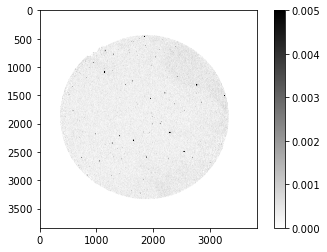

In [63]:
plt.imshow(data1,vmax=0.005,cmap='binary')
plt.colorbar()
plt.show()

## Additional Resources

For more information about the MAST archive and details about the tutorial: 

<a href="https://mast.stsci.edu/api/v0/index.html">MAST API</a> <br>
<a href="https://galex.stsci.edu/GR6/">GALEX via MAST</a> <br>

## About this Notebook

**Author**: Clara Puerto Sánchez <br>
**Updated on**: 03/08/2022

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>